In [1]:
import cv2
from google.colab.patches import cv2_imshow
print(cv2.__version__)
import numpy as np
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt
import pandas as pd

4.1.2


In [2]:
from google.colab import drive
drive.mount('//content//gdrive')


Drive already mounted at //content//gdrive; to attempt to forcibly remount, call drive.mount("//content//gdrive", force_remount=True).


In [3]:
cap = cv2.VideoCapture('/content/gdrive/MyDrive/Domaci1_KV/xo2c.avi')

In [4]:
def cut_roi(edges,image):
  #prolazi se kroz masku (izdvojene ivice) sa leve strane da se pronadje prvi beli piksel
  c=0
  i1=0
  while c==0:
    if sum(edges[i1,:])==0:
      i1+=1
    else:
      c=1
  # prolazi se kroz masku (izdvojene ivice) sa desne strane da se pronadje prvi beli piksel
  c = 0
  i2= edges.shape[0]-1
  while c == 0:
    if sum(edges[i2, :]) == 0:
      i2 -= 1
    else:
      c = 1
  # prolazi se kroz masku (izdvojene ivice) od gore da se pronadje prvi beli piksel
  c = 0
  j1 = 0
  while c == 0:
    if sum(edges[:, j1]) == 0:
      j1 += 1
    else:
      c = 1
  # prolazi se kroz masku (izdvojene ivice) od dole da se pronadje prvi beli piksel
  c = 0
  j2 = edges.shape[1]-1
  while c == 0:
    if sum(edges[:, j2]) == 0:
      j2 -= 1
    else:
      c = 1
  #isecanje
  roi_mask=edges[i1:i2,j1:j2]
  image_roi=image[i1:i2,j1:j2]

  return roi_mask,image_roi

In [5]:
def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.

    Returns closest integer pixel locations.
    See https://stackoverflow.com/a/383527/5087436
    """
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [[x0, y0]]


def segmented_intersections(lines):
    """Finds the intersections between groups of lines."""

    intersections = []
    for i, group in enumerate(lines[:-1]):
        for next_group in lines[i+1:]:
            for line1 in group:
                for line2 in next_group:
                    intersections.append(intersection(line1, line2)) 
    return intersections

In [6]:
from collections import defaultdict
def segment_by_angle_kmeans(lines, k=2, **kwargs):
    """Groups lines based on angle with k-means.

    Uses k-means on the coordinates of the angle on the unit circle 
    to segment `k` angles inside `lines`.
    """

    # Define criteria = (type, max_iter, epsilon)
    default_criteria_type = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    criteria = kwargs.get('criteria', (default_criteria_type, 10, 1.0))
    flags = kwargs.get('flags', cv2.KMEANS_RANDOM_CENTERS)
    attempts = kwargs.get('attempts', 10)

    # returns angles in [0, pi] in radians
    angles = np.array([line[0][1] for line in lines])
    # multiply the angles by two and find coordinates of that angle
    pts = np.array([[np.cos(2*angle), np.sin(2*angle)]
                    for angle in angles], dtype=np.float32)

    # run kmeans on the coords
    labels, centers = cv2.kmeans(pts, k, None, criteria, attempts, flags)[1:]
    labels = labels.reshape(-1)  # transpose to row vec

    # segment lines based on their kmeans label
    segmented = defaultdict(list)
    for i, line in enumerate(lines):
        segmented[labels[i]].append(line)
    segmented = list(segmented.values())
    return segmented

In [7]:
def minmax(lista):
        x_vred = []
        y_vred = []
        if len(lista) ==4:
          for i in range(0,4):
            x = lista[i][0][0]
            x_vred.append(x)
            y = lista[i][0][1]
            y_vred.append(y)
          
            min_vr_x = np.min(x_vred)
            max_vr_x = np.max(x_vred)
            min_vr_y = np.min(y_vred)
            max_vr_y = np.max(y_vred)
          

        else:
            min_vr_x = 50
            max_vr_x = 100
            min_vr_y = 50
            max_vr_y = 100
                  
        return min_vr_x, max_vr_x, min_vr_y, max_vr_y

In [8]:
def detectShape( img ):
    #input parameter is gray image
    shape = "NA"   # initialize the shape as NA - not available
                                                                          
    # convert image to grayscale and add slight blur:
    gray_img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    gray_img= cv2.convertScaleAbs(gray_img2) #konvertujemo u osmobitnu sliku
    blurred_img = cv2.GaussianBlur(gray_img, (3, 3), 0)
    
    # threshold image to create a binary image
    thresh_img = cv2.threshold(blurred_img, 170, 255, cv2.THRESH_BINARY)[1]
    
    contour_list, hier = cv2.findContours(thresh_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)   # find contours of thresholded image
    #contour_list = imutils.grab_contours(contour_list)                                      # <- store contours in list/sequence
    #print(len(contour_list))
    
    cX_lista = []
    cY_lista = []
    cX_lista_O = []
    cY_lista_O = []
    cX_lista_X = []
    cY_lista_X = []
    shapes = []


    for c in range(len(contour_list)):
        perimiter = cv2.arcLength(contour_list[c], True)                     # calculate te perimiter of the detected object/shape
        approx = cv2.approxPolyDP(contour_list[c], 0.04 * perimiter, True)   # built-in function for approximating the detected contour ->


        M = cv2.moments(contour_list[c])                     # find countour centres using geometric moments
        try:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        except:
            continue

        # print('Value of approx is: ', len(approx))    # this line is used for testing
        # print(len(approx))

        if ((len(approx) <= 4) or (len(approx) >=9)):      # rectangle or border detected -> skip
            continue
        elif ((len(approx) >= 5) and (len(approx) <=7)):  # circle detected
            shape = "O"
            cX_lista_O.append(cX)
            cY_lista_O.append(cY) 
            shapes.append(shape)
        else:                                        # anything else is X -> assuming players are only allowed to put 'X' or 'O'
            shape = "X"
            cX_lista_X.append(cX)
            cY_lista_X.append(cY)
            shapes.append(shape)
        

    return cX_lista_O, cY_lista_O,cX_lista_X, cY_lista_X, shapes

In [9]:
def polja_za_X(minx, maxx, miny, maxy, cXi,cYi,popunjena_mreza):
  if cXi < minx and cYi < miny:
    popunjena_mreza[0,0] = 1
  elif cXi<minx and miny<cYi and cYi<maxy:
    popunjena_mreza[1,0] = 1
  elif cXi<minx and cYi>maxy:
    popunjena_mreza[2,0] = 1
  elif minx<cXi and cXi<maxx and cYi<miny:
    popunjena_mreza[0,1] = 1
  elif minx < cXi and cXi<maxx and cYi>miny and cYi<maxy:
    popunjena_mreza[1,1] = 1
  elif minx<cXi and cXi <maxx and cYi>maxy:
    popunjena_mreza[2,1] = 1
  elif cXi >maxx and cYi< miny:
    popunjena_mreza[0,2] = 1
  elif cXi > maxx and cYi>miny and cYi<maxy:
    popunjena_mreza[1,2] = 1
  elif cXi > maxx and cYi>maxy:
    popunjena_mreza[2,2] = 1
    
  return popunjena_mreza

In [10]:
def polja_za_O(minx, maxx, miny, maxy, cXi,cYi,popunjena_mreza):
  if cXi < minx and cYi < miny:
    popunjena_mreza[0,0] = -1
  elif cXi<minx and miny<cYi and cYi<maxy:
    popunjena_mreza[1,0] = -1
  elif cXi<minx and cYi>maxy:
    popunjena_mreza[2,0] = -1
  elif minx<cXi and cXi<maxx and cYi<miny:
    popunjena_mreza[0,1] = -1
  elif minx < cXi and cXi<maxx and cYi>miny and cYi<maxy:
    popunjena_mreza[1,1] = -1
  elif minx<cXi and cXi <maxx and cYi>maxy:
    popunjena_mreza[2,1] = -1
  elif cXi >maxx and cYi< miny:
    popunjena_mreza[0,2] = -1
  elif cXi > maxx and cYi>miny and cYi<maxy:
    popunjena_mreza[1,2] = -1
  elif cXi > maxx and cYi>maxy:
    popunjena_mreza[2,2] = -1

  return popunjena_mreza


In [11]:
def proveraXO(cX_lista_X,cY_lista_X, cX_lista_O,cY_lista_O):
  #mora da se pretvori u np.array jer nije radilo prethodno
  cX_lista_X=np.array(cX_lista_X)
  cY_lista_X=np.array(cY_lista_X)
  cX_lista_X_r=cX_lista_X.reshape(len(cX_lista_X),1)
  cY_lista_X_r=cY_lista_X.reshape(len(cY_lista_X),1)
  X_parovi=np.concatenate((cX_lista_X_r,cY_lista_X_r), axis=1)

  cX_lista_O=np.array(cX_lista_O)
  cY_lista_O=np.array(cY_lista_O)
  cX_lista_O_r=cX_lista_O.reshape(len(cX_lista_O),1)
  cY_lista_O_r=cY_lista_O.reshape(len(cY_lista_O),1)
  O_parovi=np.concatenate((cX_lista_O_r,cY_lista_O_r), axis=1)
  index=100 #nije bitna vrednost, samo da nije 0 jer to moze biti prava vrednost indeksa

  for i in range(len(X_parovi)):
    for j in range(len(O_parovi)):
      a = np.array(O_parovi[i,:])
      b = np.array(O_parovi[j,:])
      c=np.sum(np.all(np.equal(a, b), axis=0))

      #ako se naidje na dve vrste koje su iste, obrisi taj par centroida za X jer je to zapravo O
      if c == 1: 
        index=i

  if index != 100:
    X_parovi=np.delete(X_parovi, index, 0)

        
  cX_lista_X_n = X_parovi[:,0]
  cY_lista_X_n = X_parovi[:,1]


  return cX_lista_X_n,cY_lista_X_n,cX_lista_O,cY_lista_O

In [12]:
positions_groups = (
    [[(x, y) for y in range(3)] for x in range(3)] + # horizontals
    [[(x, y) for x in range(3)] for y in range(3)] + # verticals
    [[(d, d) for d in range(3)]] + # diagonal from top-left to bottom-right
    [[(2-d, d) for d in range(3)]] # diagonal from top-right to bottom-left
)

def get_winner(board):
    """Return winner piece in board (None if no winner)."""
    br=0 #brojac
    winner=None
    for positions in positions_groups:
        values = [board[x][y] for (x, y) in positions]
        br=br+1
        if len(set(values)) == 1 and values[0]:
            return values[0], br
    br=9
    return winner, br

In [13]:
def winner_line(br,im_h):
  if br == 1:
    cv2.line(im_h,(158,25),(im_h.shape[1],25),(224,67,255),2)
  elif br == 2:
    cv2.line(im_h,(158,72),(im_h.shape[1],72),(224,67,255),2)
  elif br == 3:
    cv2.line(im_h,(158,122),(im_h.shape[1],122),(224,67,255),2) 
  elif br == 4:
    cv2.line(im_h,(190,0),(190,im_h.shape[0]),(224,67,255),2) 
  elif br == 5:
     cv2.line(im_h,(243,0),(243,im_h.shape[0]),(224,67,255),2) 
  elif br == 6:
    cv2.line(im_h,(295,0),(295,im_h.shape[0]),(224,67,255),2)
  elif br == 7:
    cv2.line(im_h,(158,0),(im_h.shape[1],im_h.shape[0]),(224,67,255),2)
  elif br == 8:
    cv2.line(im_h,(im_h.shape[1],0),(158,im_h.shape[0]),(224,67,255),2)
  
  else:
    tekst='NERESENO'
    cv2.putText(im_h, tekst, (160, 75), cv2.FONT_HERSHEY_SIMPLEX, 1, (53, 245, 104), 2) 


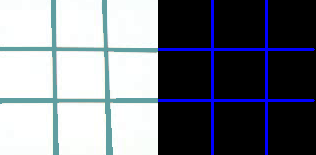

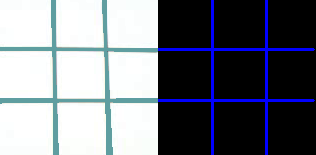

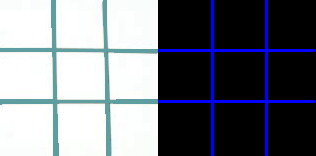

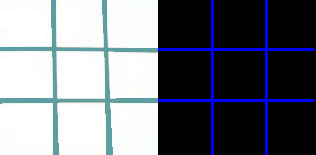

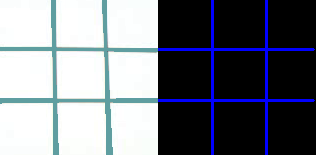

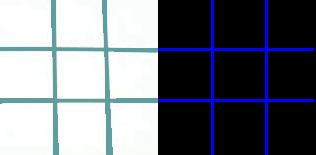

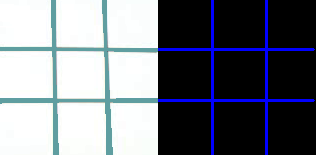

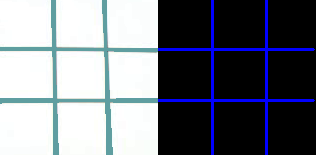

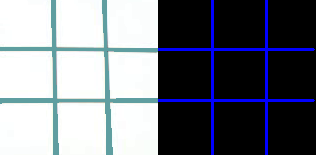

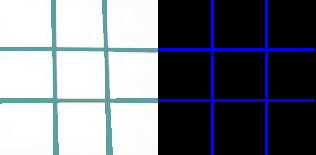

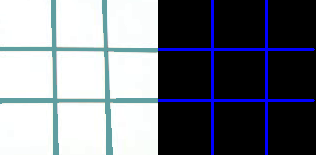

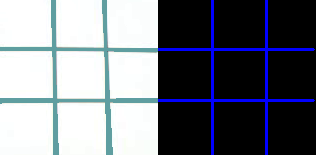

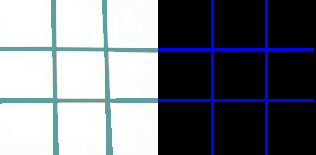

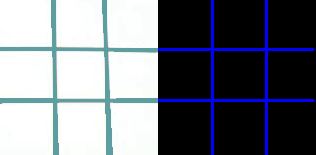

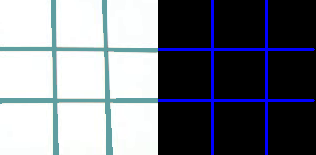

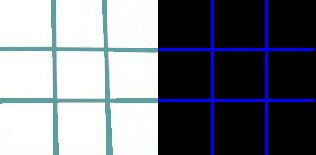

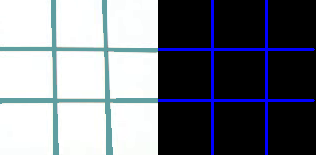

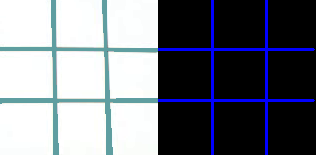

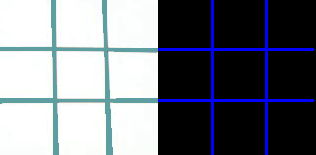

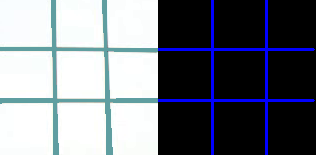

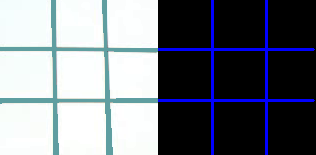

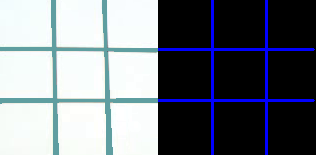

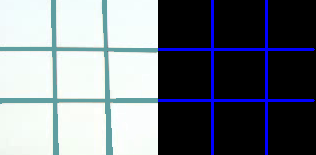

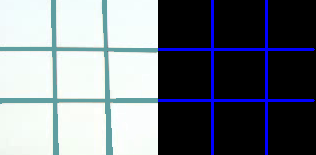

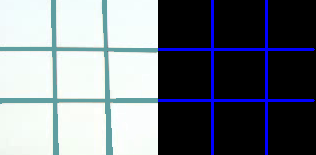

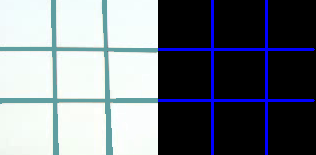

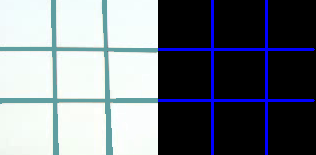

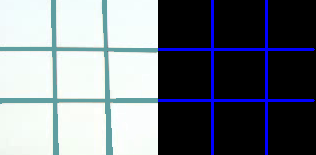

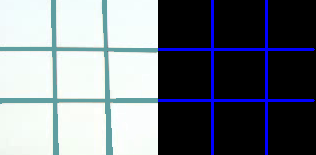

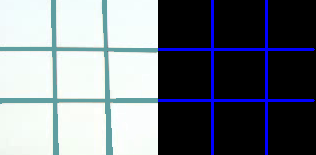

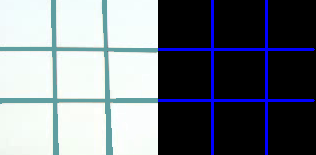

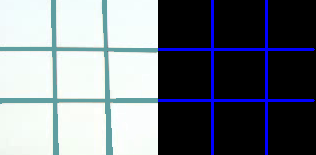

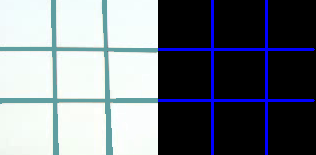

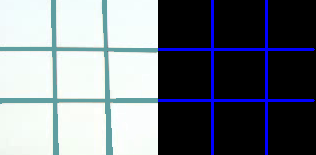

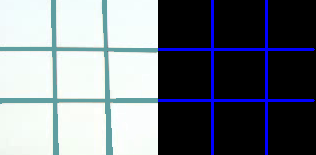

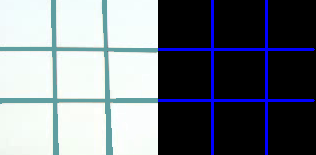

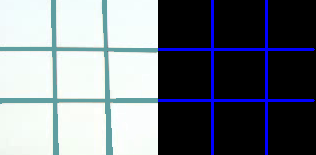

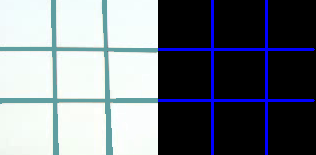

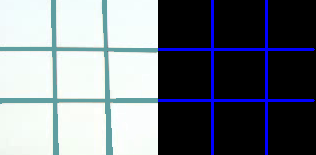

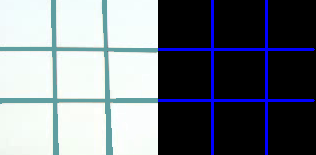

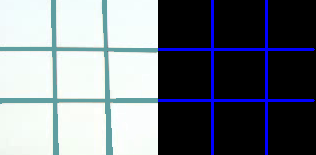

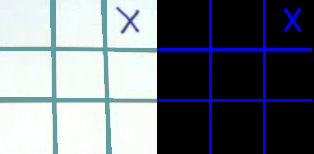

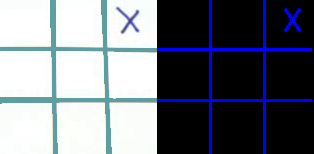

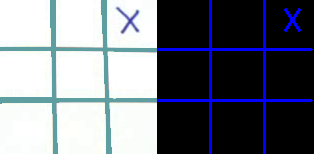

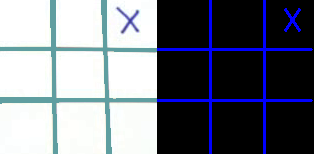

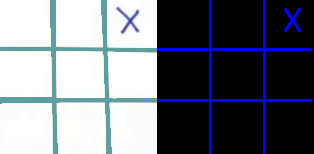

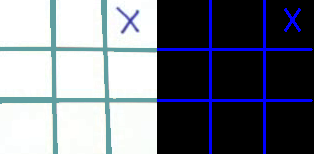

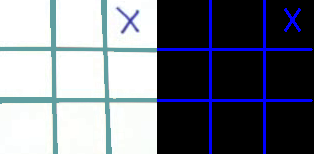

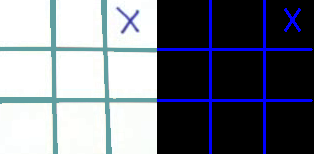

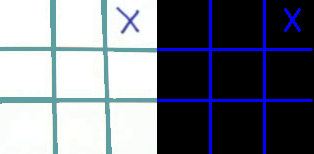

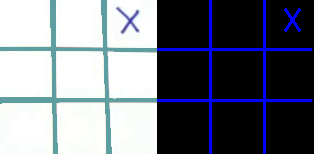

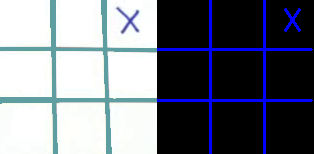

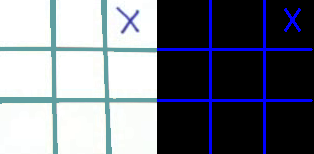

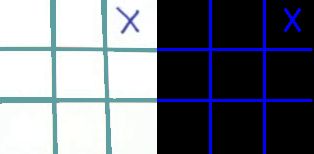

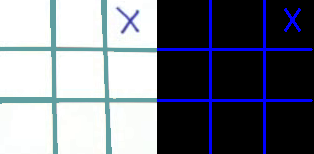

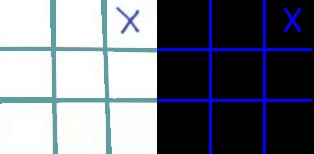

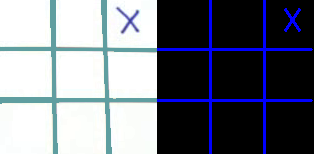

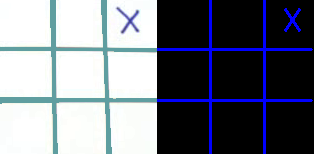

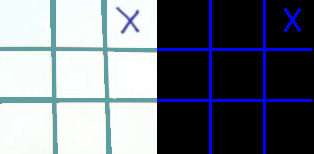

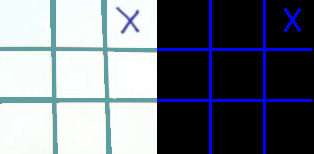

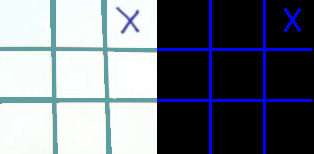

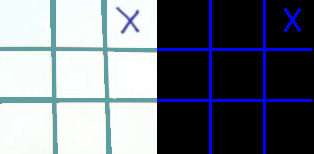

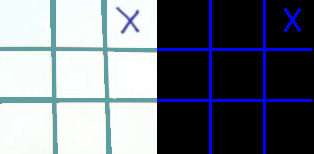

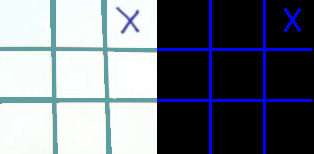

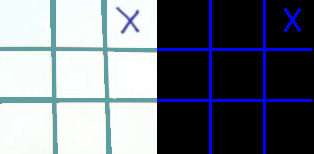

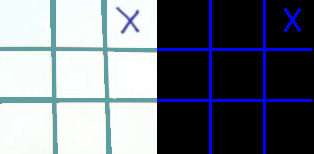

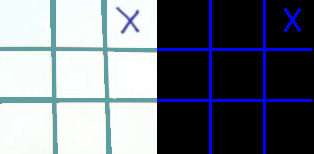

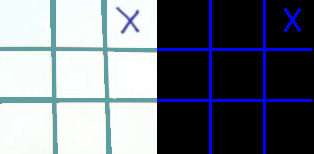

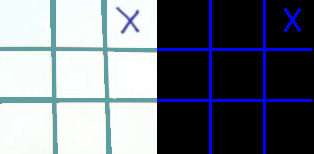

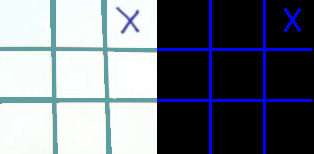

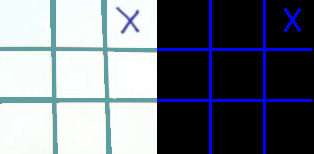

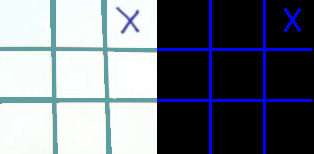

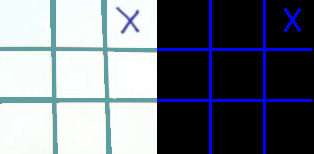

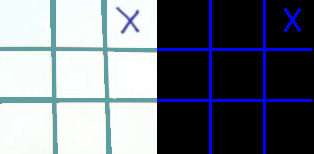

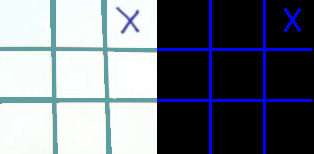

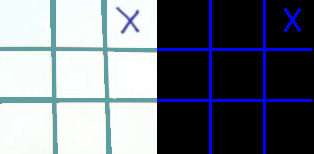

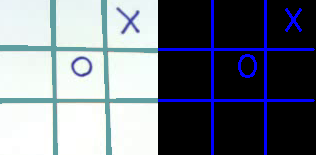

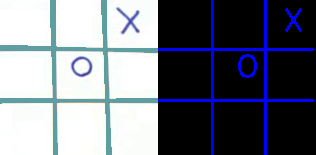

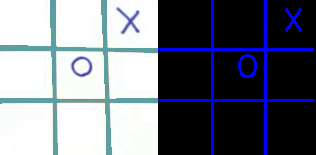

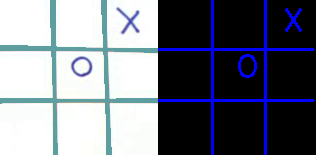

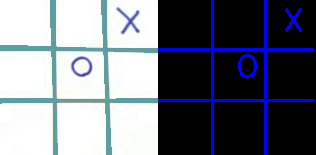

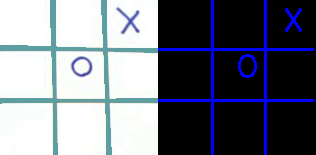

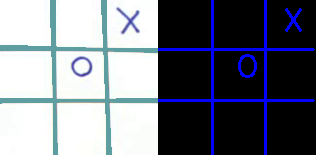

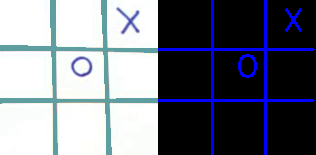

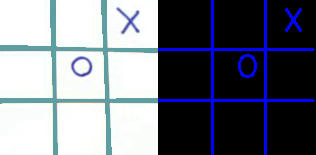

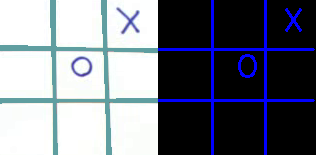

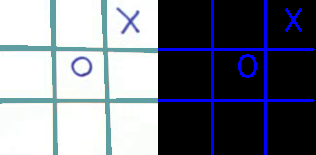

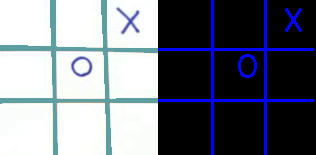

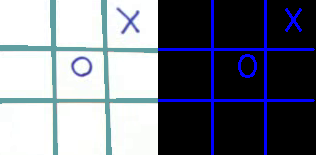

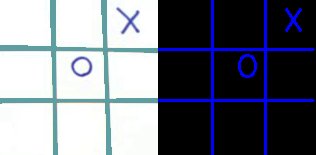

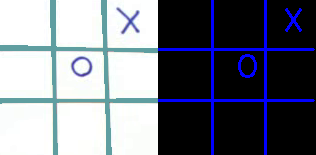

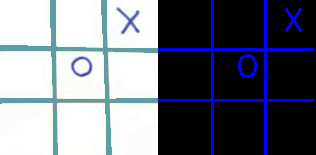

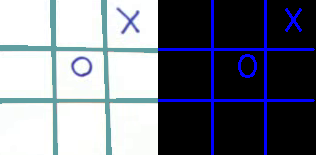

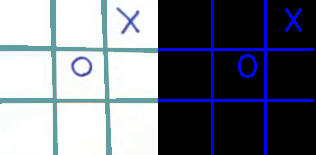

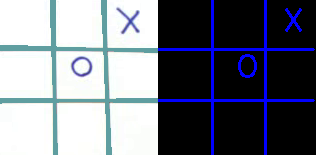

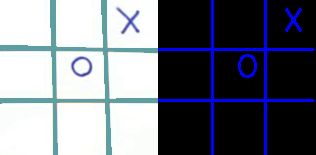

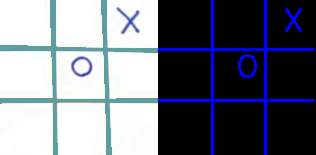

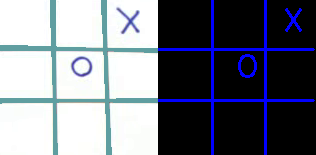

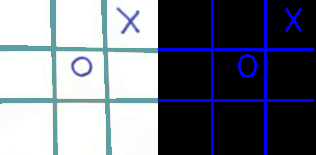

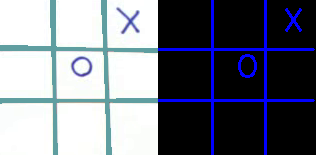

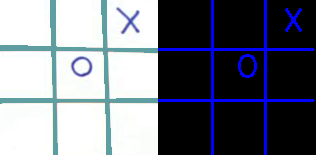

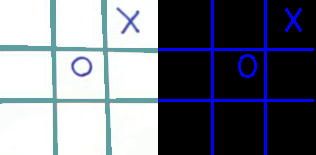

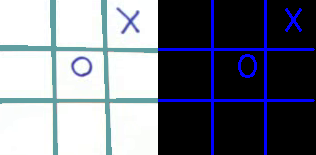

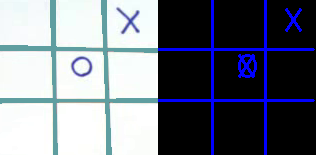

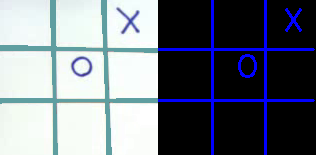

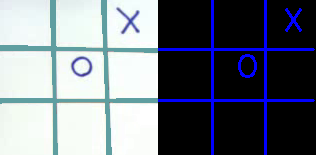

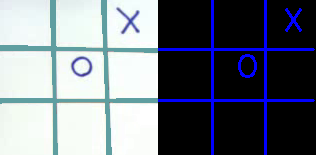

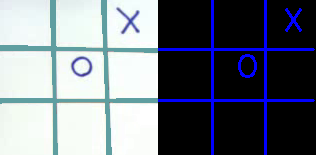

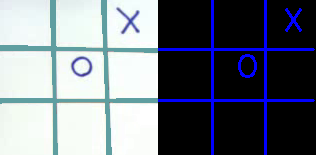

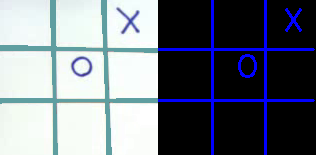

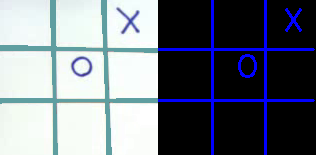

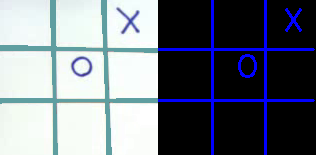

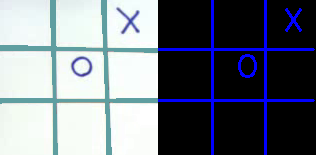

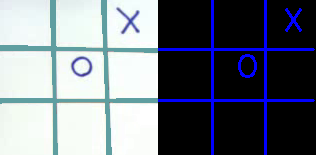

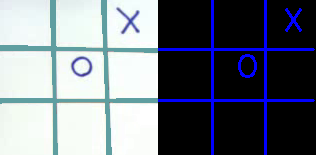

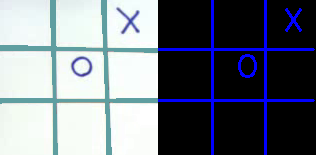

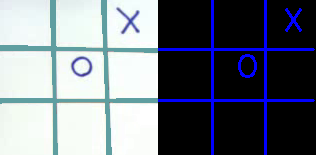

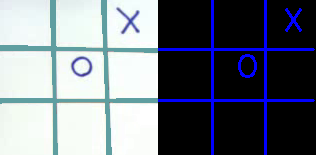

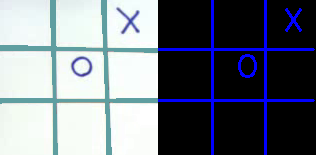

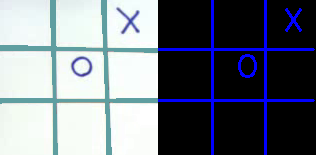

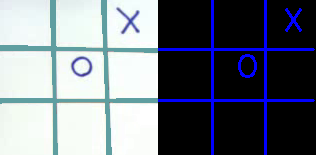

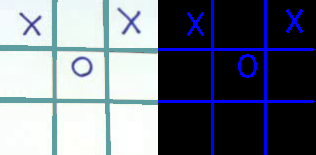

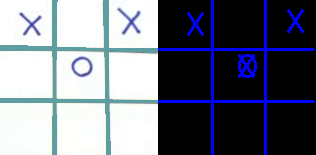

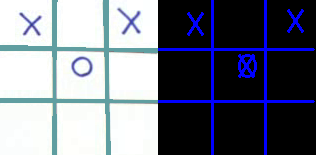

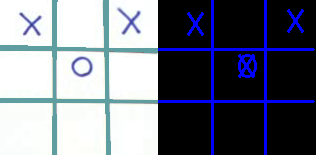

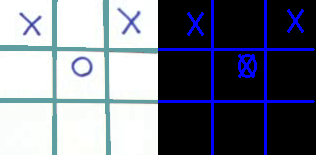

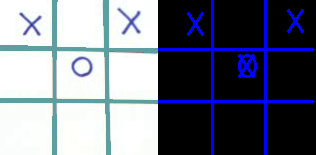

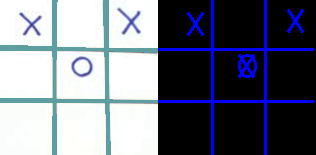

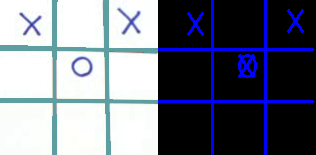

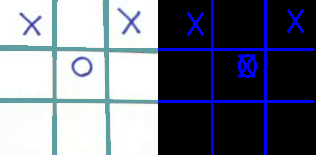

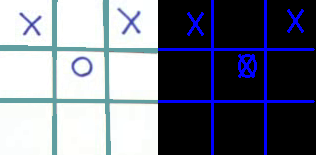

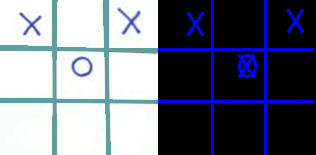

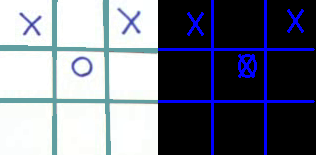

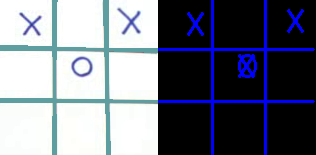

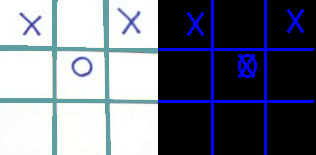

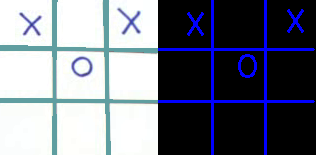

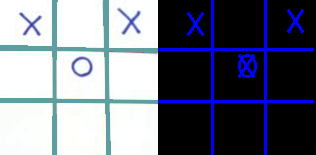

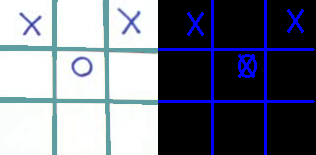

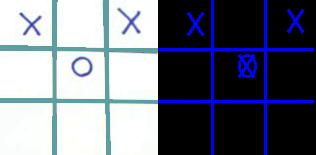

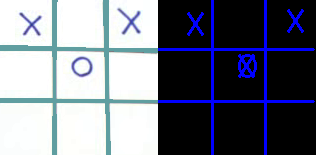

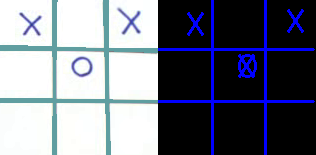

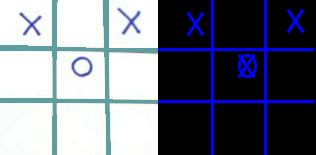

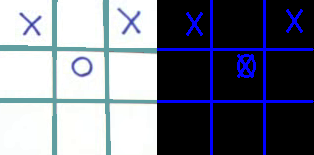

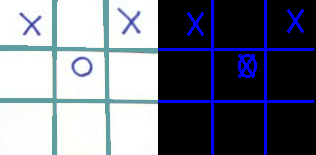

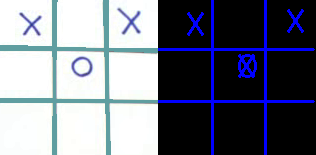

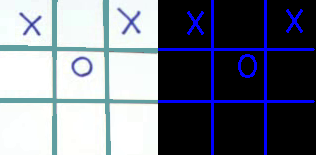

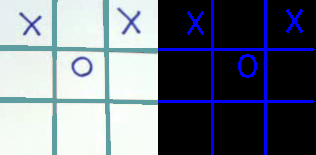

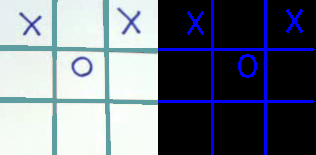

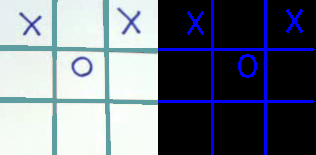

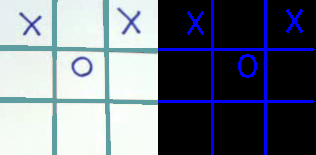

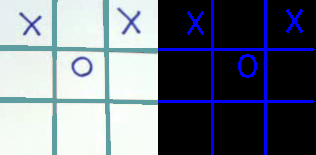

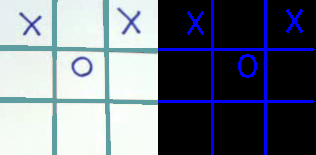

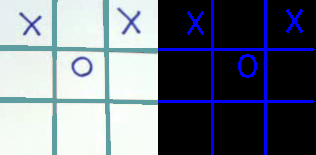

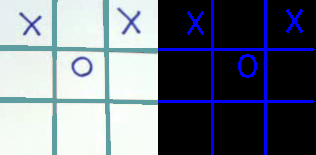

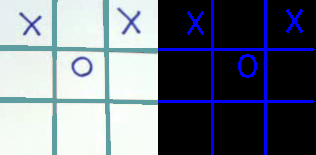

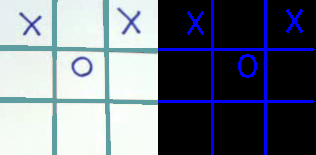

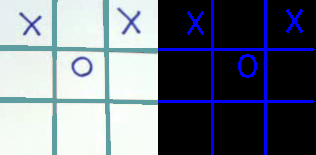

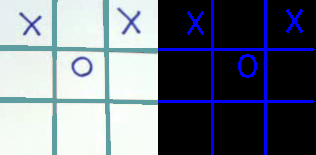

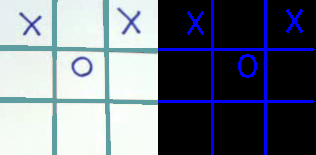

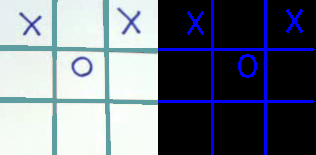

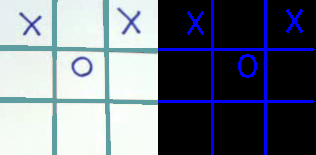

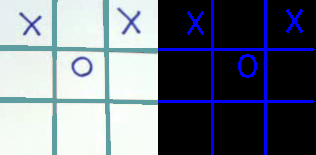

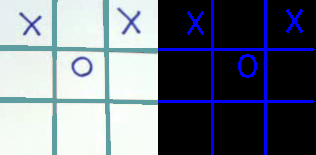

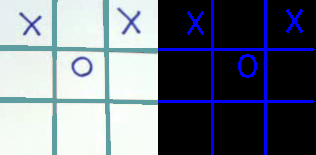

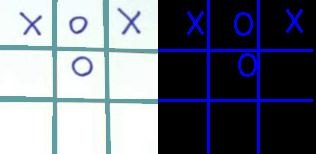

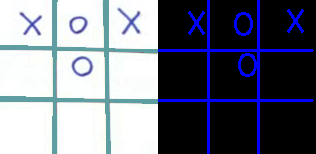

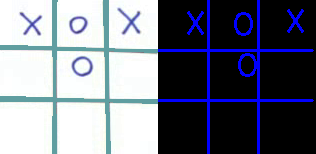

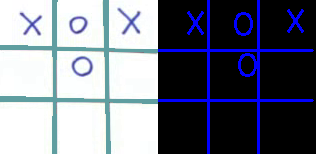

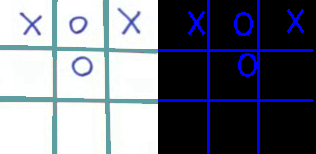

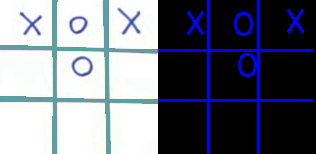

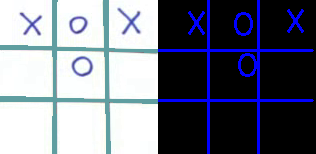

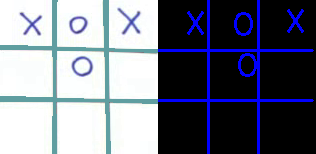

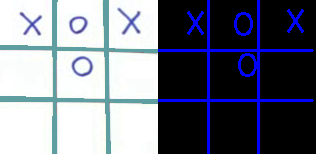

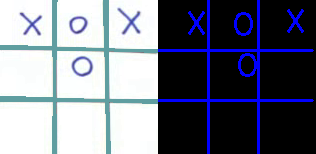

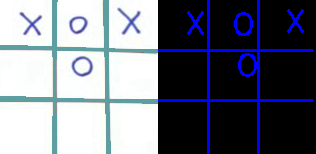

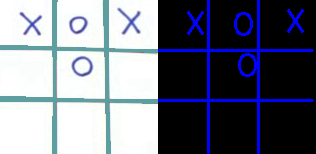

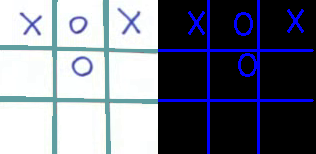

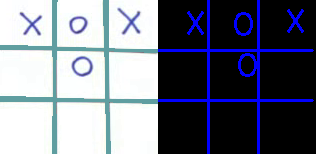

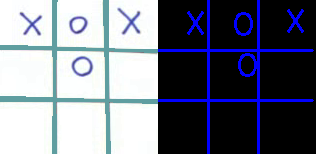

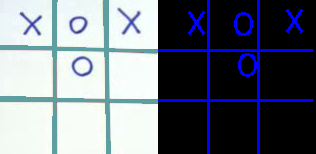

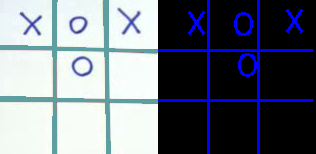

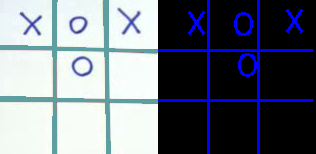

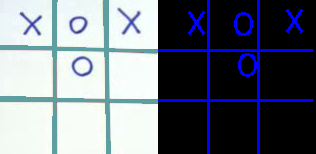

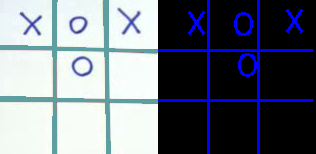

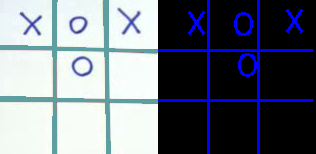

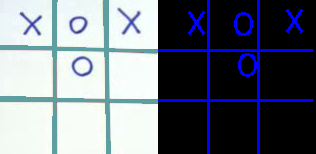

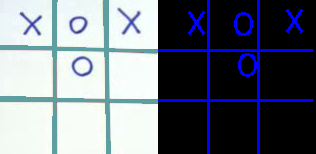

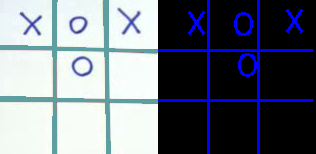

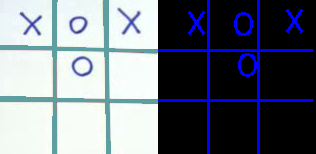

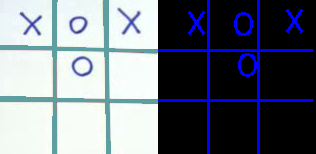

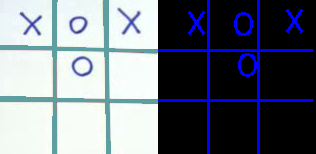

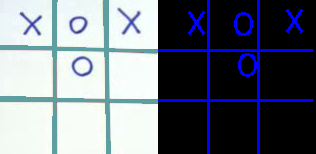

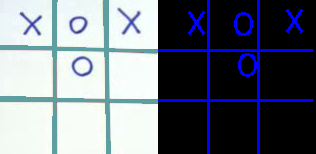

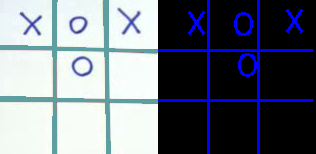

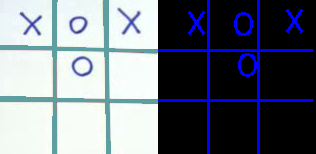

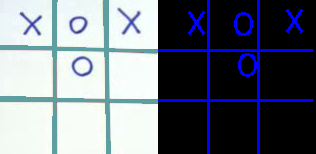

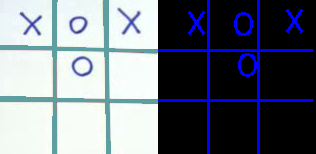

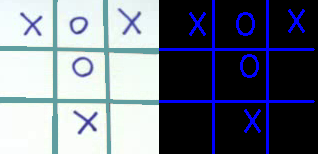

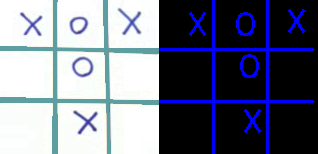

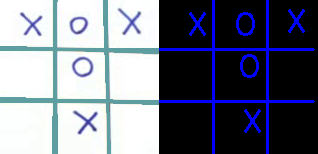

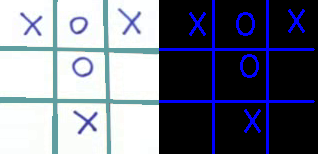

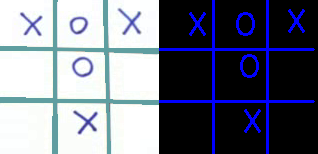

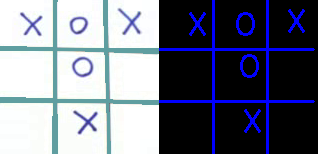

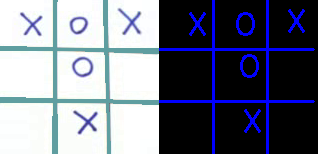

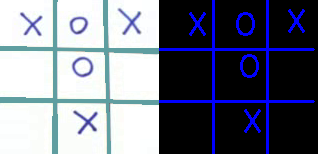

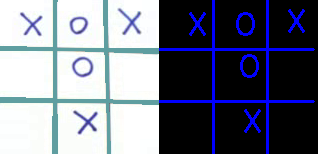

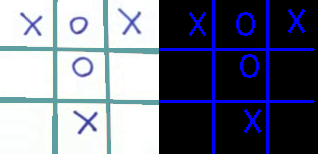

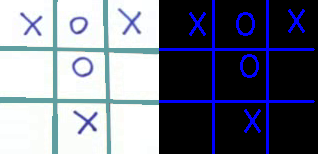

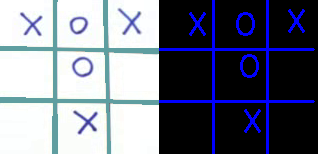

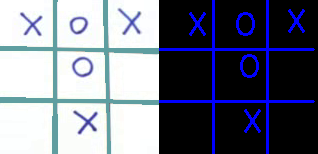

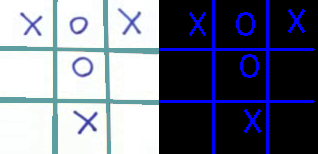

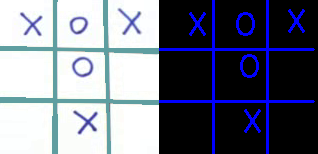

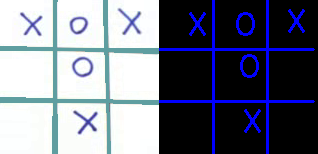

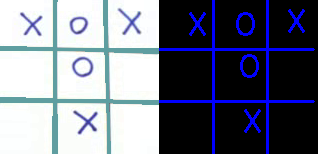

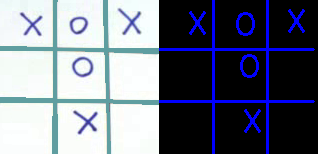

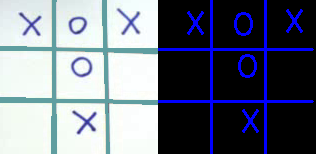

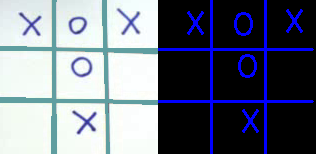

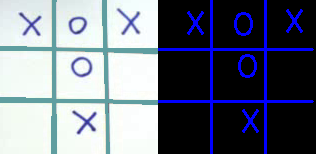

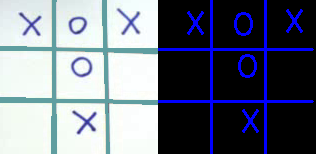

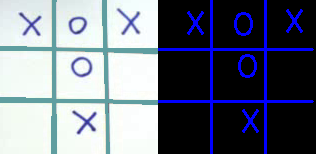

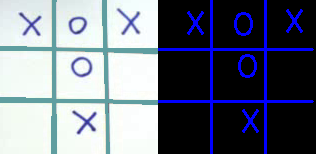

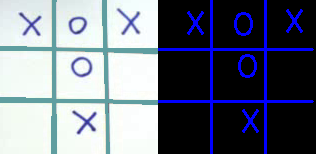

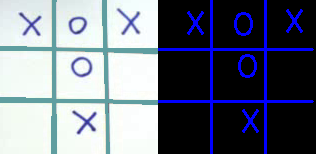

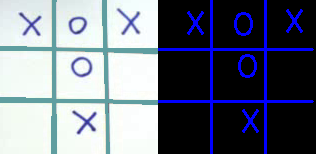

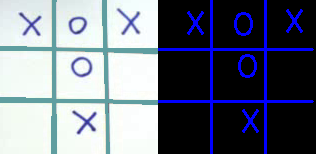

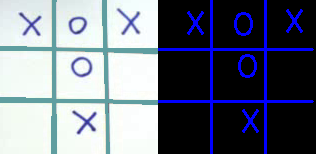

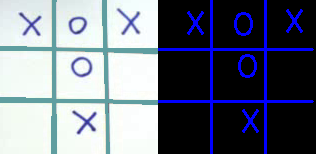

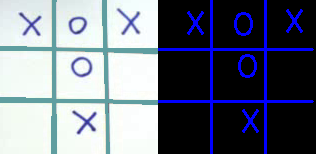

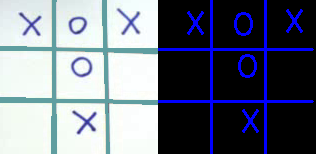

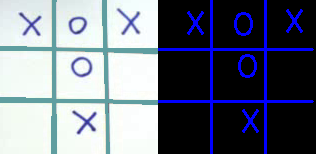

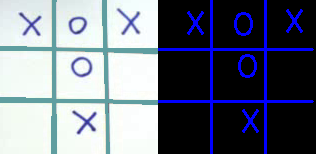

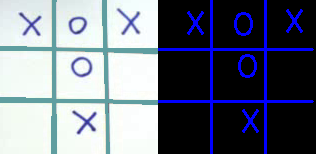

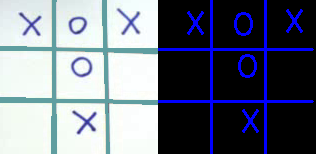

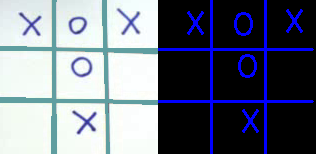

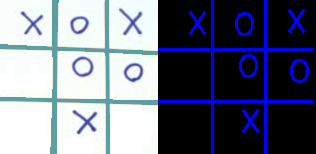

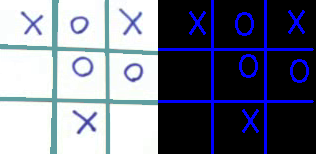

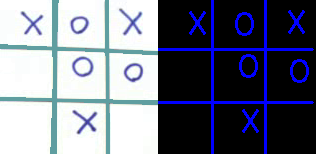

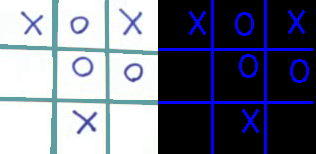

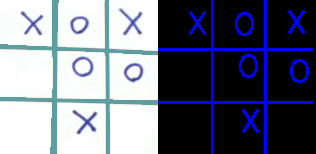

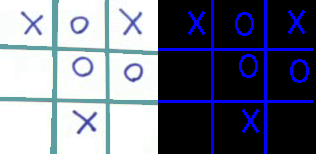

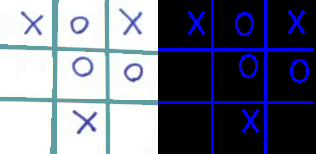

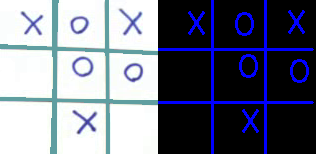

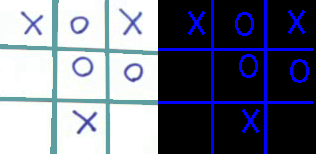

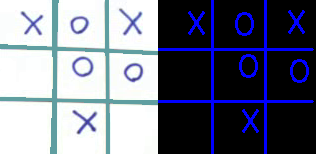

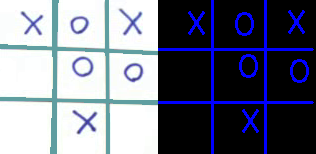

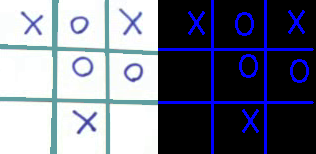

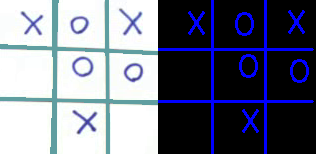

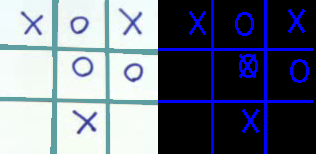

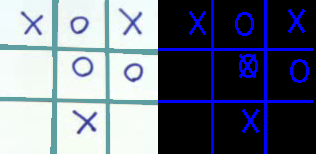

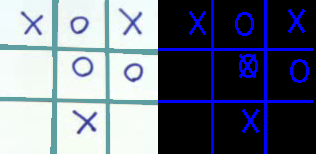

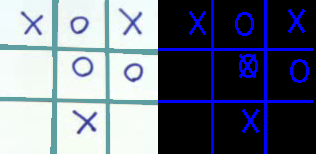

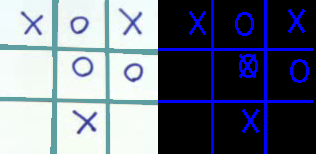

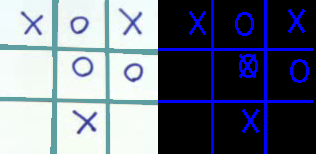

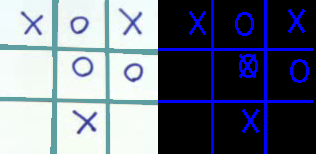

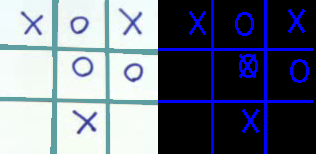

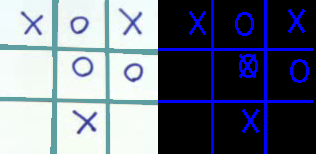

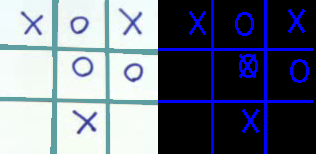

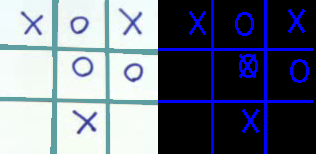

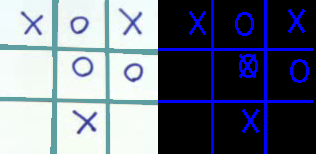

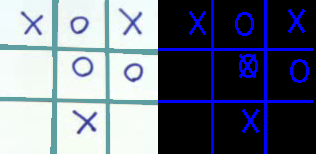

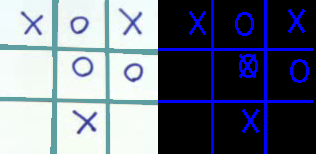

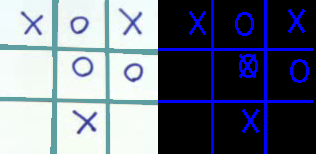

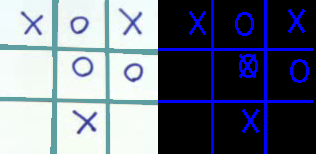

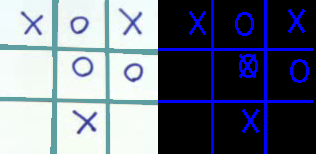

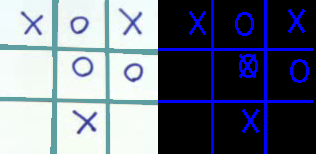

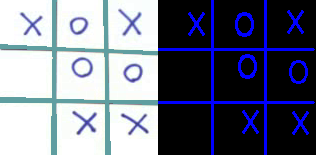

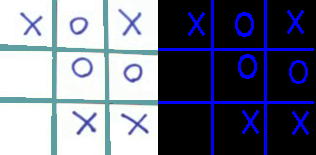

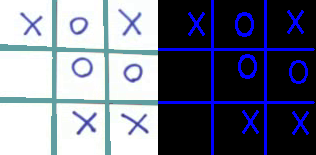

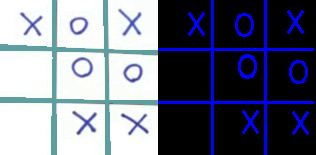

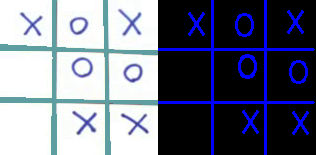

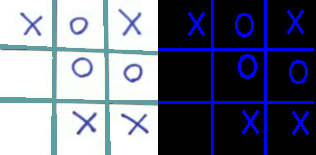

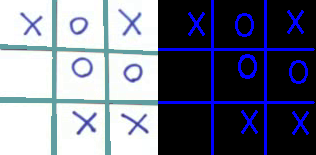

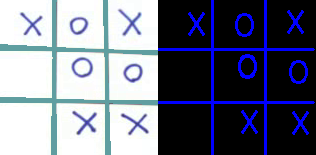

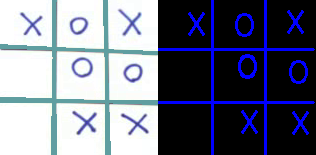

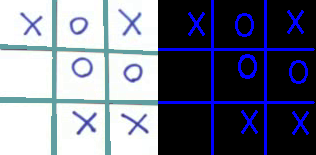

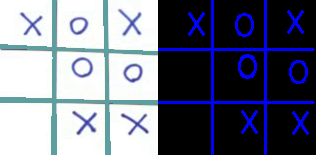

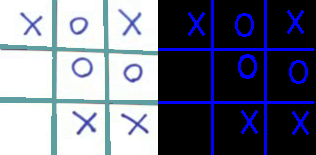

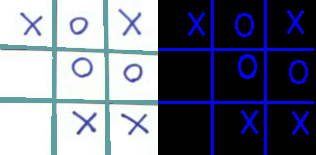

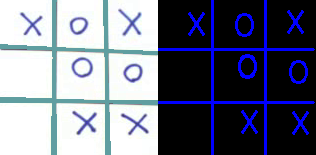

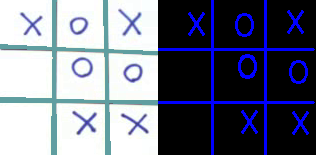

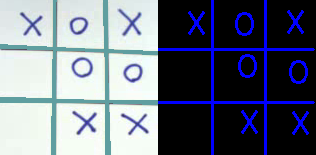

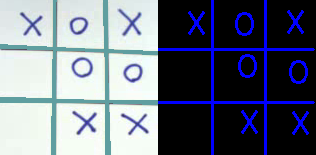

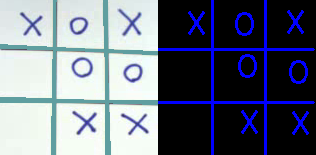

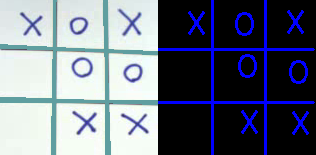

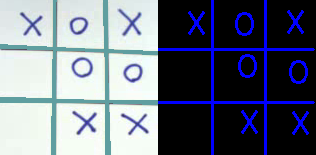

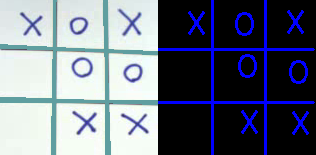

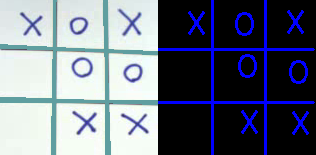

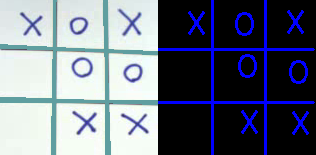

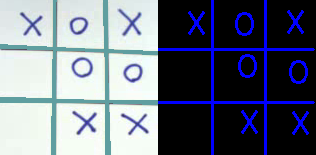

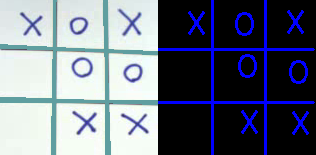

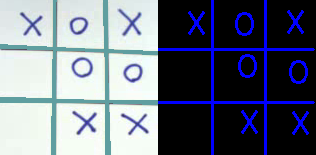

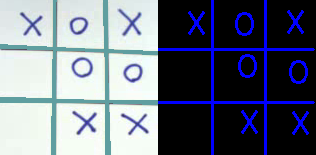

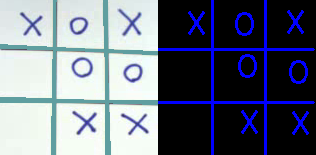

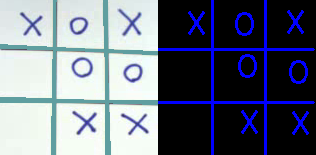

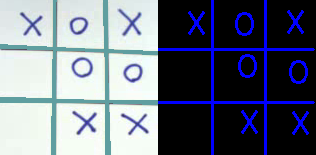

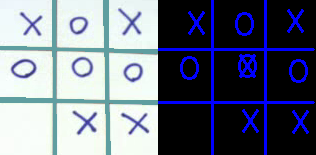

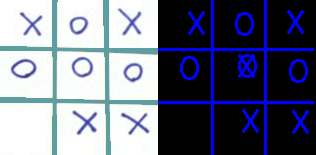

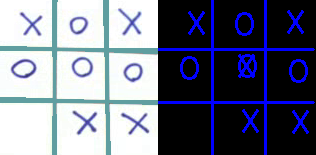

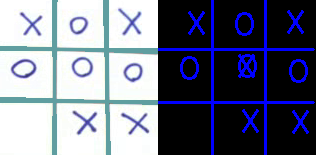

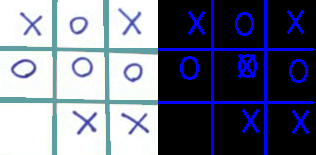

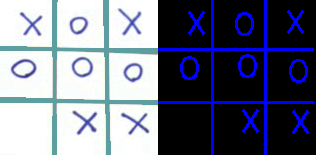

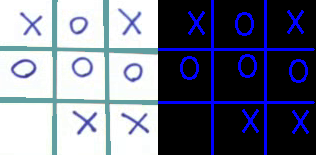

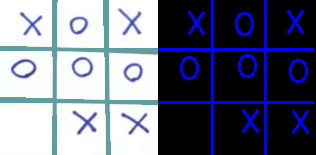

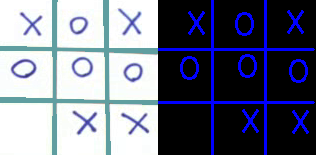

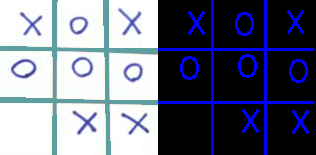

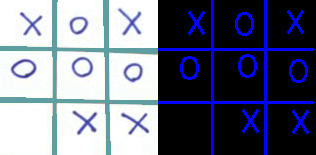

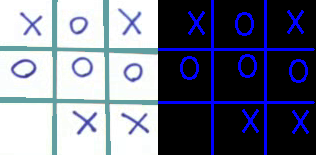

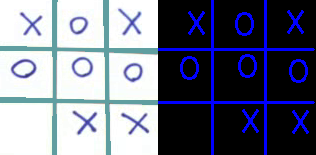

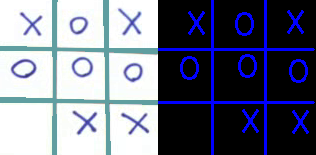

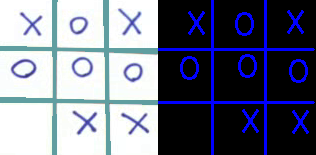

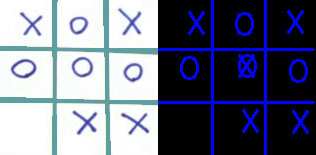

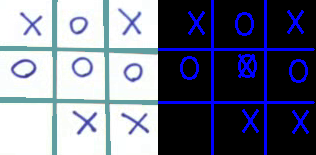

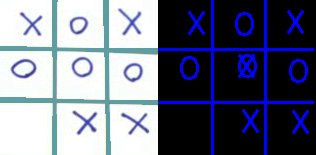

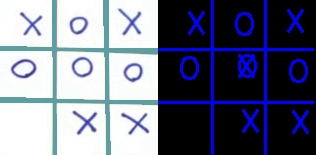

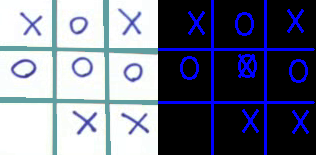

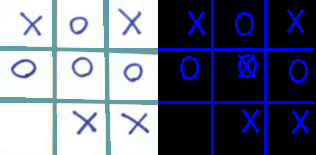

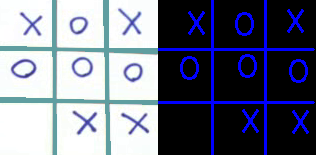

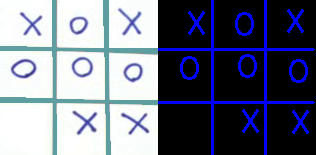

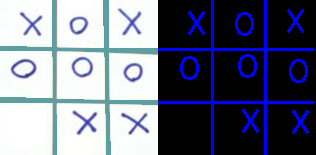

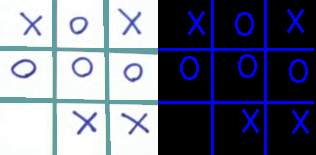

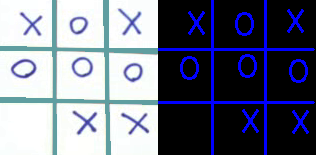

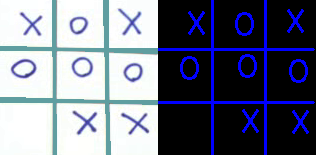

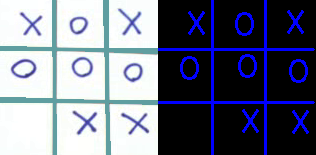

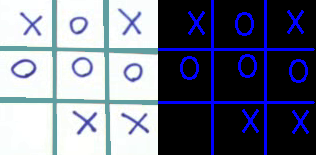

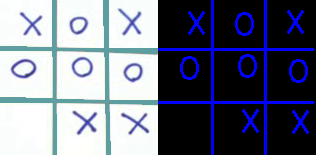

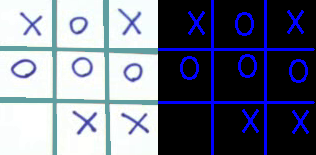

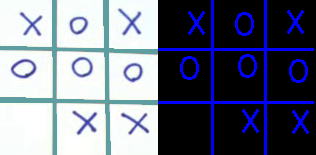

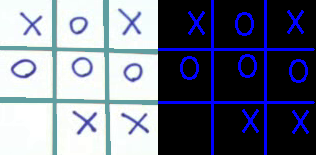

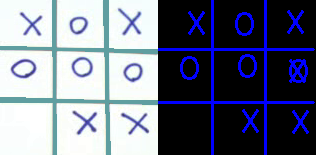

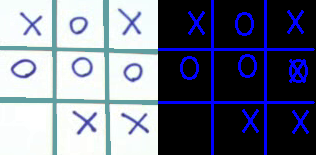

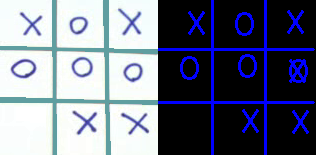

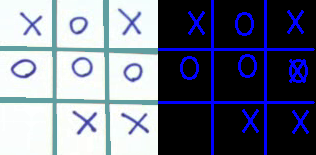

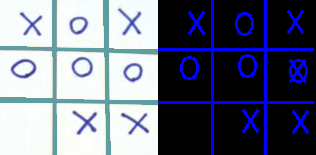

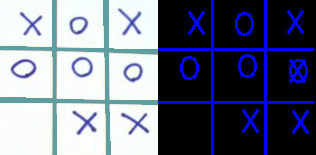

Pobedio je igrac O


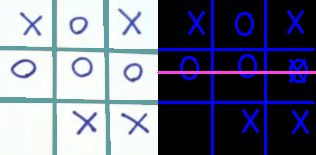

In [14]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from statistics import stdev
ruka = []
strong_lines = np.zeros([4,1,2])
while True:
    ret, frame1 = cap.read()
    
    if ret == True:
      frame = frame1[0:350,100:550]
      #cv2_imshow(frame)
      gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
      st = gray.std()

      if st <32:

        edges_1 = cv2.Canny(gray, 100, 150, apertureSize=3)
        rect = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        dilation = cv2.dilate(edges_1, rect, iterations=2)
        erosion = cv2.erode(dilation, rect, iterations=3)
        edges_2=erosion
        edges, frame2 = cut_roi(edges_2,frame) #prikaz mreze u boji
        
        edges_gray,frame2_gray=cut_roi(edges_2,gray)#siva slika za dalji rad
        #cv2_imshow(edges)
        print('')

        # Hafova transformacija
        lines = cv2.HoughLines(edges_gray,1,np.pi/180,100)
        for line in lines:
          rho,theta = line[0]
          a = np.cos(theta)
          b = np.sin(theta)
          x0 = a*rho
          y0 = b*rho
          x1 = int(x0 + 1000*(-b))
          y1 = int(y0 + 1000*(a))
          x2 = int(x0 - 1000*(-b))
          y2 = int(y0 - 1000*(a))

          cv2.line(frame2,(x1,y1),(x2,y2),(160,158,95),2)

        
        n2 = 0
        for n1 in range(0,len(lines)):
            for rho,theta in lines[n1]:
                if n1 == 0:
                    strong_lines[n2] = lines[n1]
                    n2 = n2 + 1
                else:
                    if rho < 0:
                      rho*=-1
                      theta-=np.pi
                    closeness_rho = np.isclose(rho,strong_lines[0:n2,0,0],atol = 10)
                    closeness_theta = np.isclose(theta,strong_lines[0:n2,0,1],atol = np.pi/36)
                    closeness = np.all([closeness_rho,closeness_theta],axis=0)
                    if not any(closeness) and n2 < 4:
                        strong_lines[n2] = lines[n1]
                        n2 = n2 + 1
        segmented = segment_by_angle_kmeans(strong_lines)
        intersections = segmented_intersections(segmented) 
        minx, maxx, miny, maxy = minmax(intersections)
        [xkraj,ykraj,zvrednost]=frame2.shape
        papir=np.zeros((xkraj,ykraj,3), np.uint8)
        cv2.line(papir,(0,miny),(xkraj,miny),(255,0,0),2)
        cv2.line(papir,(0,maxy),(xkraj,maxy),(255,0,0),2)
        cv2.line(papir,(minx,0),(minx,ykraj),(255,0,0),2)
        cv2.line(papir,(maxx,0),(maxx,ykraj),(255,0,0),2)
 
        #detekcija kontura i odredjivanje objekata
        shape = "NA"   
        #ulazni parametar je gray slika                                                                         # initialize the shape as NA - not available

                                                                       
        # convert image to grayscale and add slight blur:
        gray_img2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        #konverzija u 8bitnu sliku
        gray_img= cv2.convertScaleAbs(gray_img2)
        blurred_img = cv2.GaussianBlur(gray_img, (3, 3), 0)

        # threshold image to create a binary image
        thresh_img = cv2.threshold(blurred_img, 170, 255, cv2.THRESH_BINARY)[1]
        #cv2_imshow('Thresholded video', thresh_img)
        
        contour_list, hier = cv2.findContours(thresh_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)   # find contours of thresholded image
        #contour_list = imutils.grab_contours(contour_list)                                      # <- store contours in list/sequence
        #print(len(contour_list))
        #print(hier)
        
        for c in range(len(contour_list)):
            perimiter = cv2.arcLength(contour_list[c], True)                     # calculate te perimiter of the detected object/shape
            approx = cv2.approxPolyDP(contour_list[c], 0.04 * perimiter, True)   # built-in function for approximating the detected contour ->


            M = cv2.moments(contour_list[c])                     # find countour centres using geometric moments
            try:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
            except:
                continue
            

            if ((len(approx) <= 4) or (len(approx) > 9)):      # rectangle or border detected -> skip
                continue
            elif ((len(approx) <= 7) and (len(approx) >=5)):   # circle detected
                shape = "O"
                
            else:                                               # anything else is X -> assuming players are only allowed to put 'X' or 'O'
                shape = "X"
                
            
            #cv2.drawContours(frame2, contour_list[c], -1, (0, 255, 0), 2)  
            #cv2.putText(frame2, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)                                 # draw contours
            cv2.putText(papir, shape, (cX-3, cY+10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

        
      else:
        print('')
       

    else:
      break
      

    # Prikaz rezultata
    print('')
    print('')
    im_h = cv2.hconcat([frame2, papir])
    cv2_imshow(im_h)


    #height, width = frame2.shape[:2]
    #shape = (width, height) 
    width  = cap.get(cv2.CAP_PROP_FRAME_WIDTH)   
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    shape=(316,155)
    video_write = cv2.VideoWriter('/content/gdrive/MyDrive/Domaci1_KV/output.mp4', fourcc, 20.0,shape)
    #fourcc = cv2.VideoWriter_fourcc('X', 'V', 'I', 'D') # svaki frejm kao sliku dodajemo videu
    #out = cv2.VideoWriter("/content/gdrive/MyDrive/Domaci1_KV/output.mp4", fourcc, 29.97, (1080, 1920)) # fps, (w,h)

cv2.imwrite('/content/gdrive/MyDrive/Domaci1_KV/last_frame.jpg', frame2)
poslednji_frame = cv2.imread('/content/gdrive/MyDrive/Domaci1_KV/last_frame.jpg')

cX_lista_O, cY_lista_O,cX_lista_X, cY_lista_X, shapes = detectShape(poslednji_frame)

cX_lista_X,cY_lista_X,cX_lista_O,cY_lista_O = proveraXO(cX_lista_X,cY_lista_X,cX_lista_O,cY_lista_O)

popunjena_mreza = np.zeros([3,3])               

for i in range(0, len(cX_lista_X)):
  for j in range(0, len(cY_lista_X)):
    if i ==j:
      parxX = cX_lista_X[i]
      paryX = cY_lista_X[j]
      popunjena_mreza = polja_za_X(minx, maxx,miny,maxy,parxX,paryX,popunjena_mreza)

for i in range(0, len(cX_lista_O)):
  for j in range(0, len(cY_lista_O)):
    if i ==j:
      parxO = cX_lista_O[i]
      paryO = cY_lista_O[j]
      popunjena_mreza = polja_za_O(minx, maxx,miny,maxy,parxO,paryO,popunjena_mreza)


winner, br = get_winner(popunjena_mreza)

if winner == -1:
  print('Pobedio je igrac O')
  winner_line(br,im_h)
  cv2_imshow(im_h)
elif winner == 1:
  print('Pobedio je igrac X!')
  winner_line(br,im_h)
  cv2_imshow(im_h)
elif winner == None or winner == 0:
  print('Neresen rezultat!')
  winner_line(br,im_h)
  cv2_imshow(im_h)


  
